#Homework 1: Logistic regression from scratch

In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 8]

In [4]:
np.random.seed(0) # fix seed for reproducibility.

# Generate data

Create and visualize dataset

In [5]:
X, y, _ = datasets.make_biclusters(shape=[1000, 2], n_clusters=2, noise=15)

In [6]:
X.shape, y.shape

((1000, 2), (2, 1000))

In [7]:
X

array([[ -2.85983969,  57.30110592],
       [ 29.54886672,  46.75235455],
       [ 64.41881336,  -2.05381385],
       ...,
       [ 12.88131229, 105.91617411],
       [ -6.54805639,  42.00512048],
       [ 77.85856734,  31.28961743]])

In [8]:
y

array([[ True,  True, False, ...,  True,  True, False],
       [False, False,  True, ..., False, False,  True]])

In [9]:
y = y[0].astype(int) 

In [10]:
X_I = np.c_[np.ones(len(X)), X]
X_I

array([[  1.        ,  -2.85983969,  57.30110592],
       [  1.        ,  29.54886672,  46.75235455],
       [  1.        ,  64.41881336,  -2.05381385],
       ...,
       [  1.        ,  12.88131229, 105.91617411],
       [  1.        ,  -6.54805639,  42.00512048],
       [  1.        ,  77.85856734,  31.28961743]])

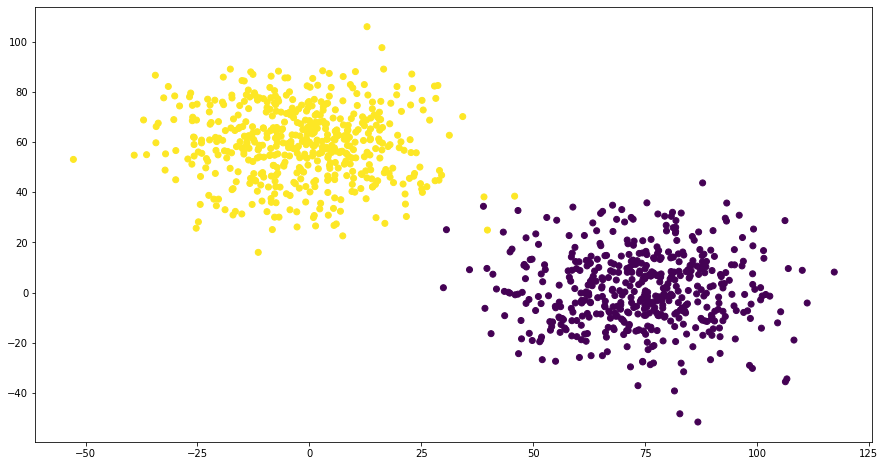

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y)

# Define model

Prediction function $y = \sigma(\theta^Tx$):

In [87]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

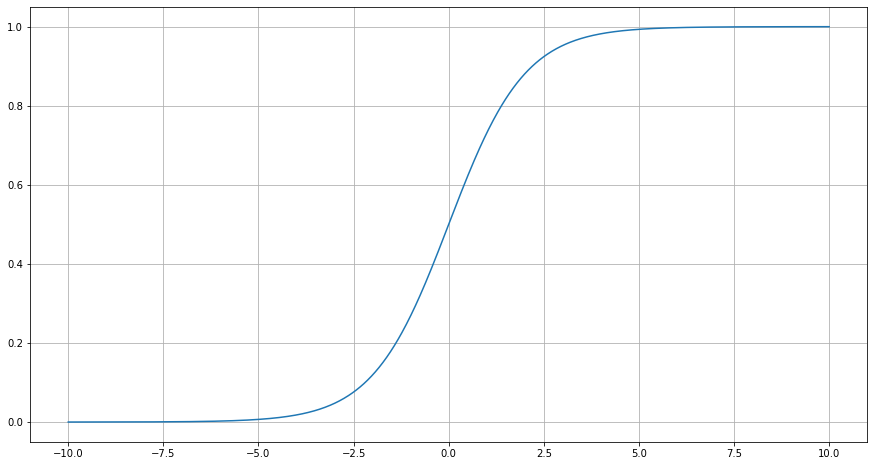

In [88]:
x = np.linspace(-10, 10, int(1e3))

plt.plot(x, sigmoid(x))
plt.grid()

In [89]:
def predict(X, theta):
    return sigmoid(np.dot(X, theta))

In [90]:
# test yourself
predict([1, 2], [3, 4])

0.999983298578152

Cost function as normalized sum of errors on the dataset: $J(\theta) = \frac{1}{2m} \sum_m(y-h_\theta(X))^2$

In [161]:
def computeCost(x_i, y, theta):
    return sum((y - predict(x_i, theta)) ** 2) / (2 * len(x_i))

In [162]:
# test yourself
computeCost(x_i=[1, 2], 
            y=[0], 
            theta=[3, 4])

0.2499916493588104

Test yourself: result should be 0.2499916493588104

Test for random weights:

In [106]:
theta = np.random.random(X_I[0].shape)
theta

array([0.85222912, 0.33631396, 0.90802934])

Check shape (should be size of dataset)

In [107]:
predict(X_I, theta).shape

(1000,)

In [108]:
computeCost(X_I, y, theta)

0.23619862695592336

Visualize model's prediction:

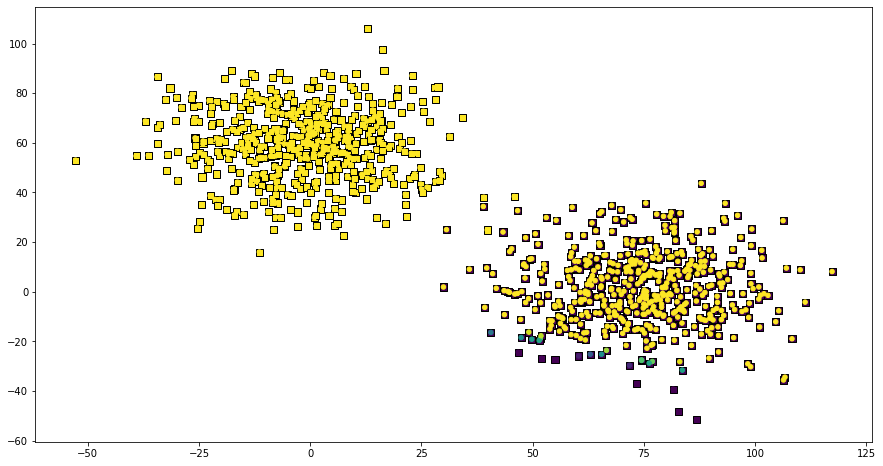

In [109]:
plt.scatter(X[:, 0], X[:, 1], c=y, label='Data', marker='s', s=50, edgecolors='k')
plt.scatter(X[:, 0], X[:, 1], c=predict(X_I, theta), s=20)

In [110]:
def visualize_grid(X, theta, resolution=100, line_only=False):
    ''' Use grid of samples to visualize decision boundary on the whole data space '''
  
    X_I = np.c_[np.ones(len(X)), X]
    minimum = np.min(X.flatten())
    maximum = np.max(X.flatten())

    # Grid of test points on whole input area
    xx, yy = np.meshgrid(np.linspace(minimum, maximum, resolution), np.linspace(minimum, maximum, resolution))
  
    grid = np.c_[xx.flatten(), yy.flatten()] # Concatenate coords to points
    grid_I = np.c_[np.ones(resolution ** 2), grid]
    
    # Prediction of each test point
    pred = predict(grid_I, theta)

    if line_only:
        mask = np.array(abs(pred - 0.5) < 0.15) # only predictions close to 0.5, to visualize decision boundary
        masked_grid = grid[mask]
        plt.scatter(masked_grid[:, 0], masked_grid[:, 1], c=pred[mask], marker='.')
    else:
        plt.scatter(grid[:, 0], grid[:, 1], c=pred, marker='.')
  
    plt.scatter(X[:, 0], X[:, 1], c=y, label='Data', marker='s', s=50, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=predict(X_I, theta), s=20)

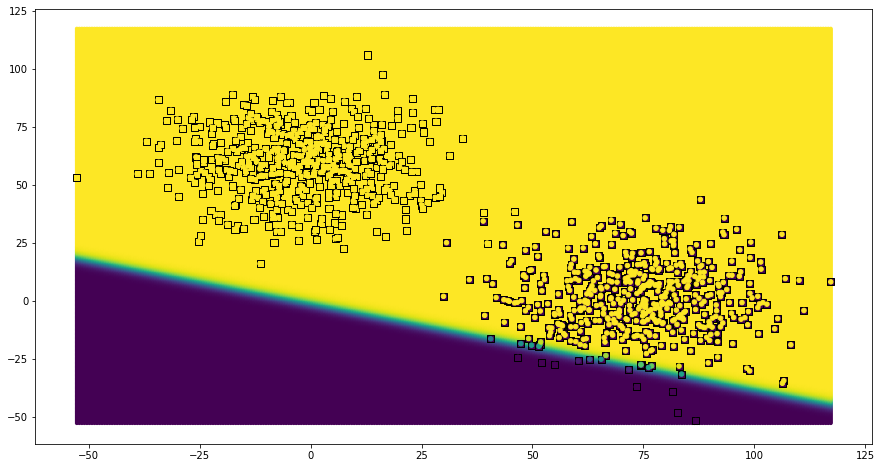

In [111]:
visualize_grid(X, theta, 300)

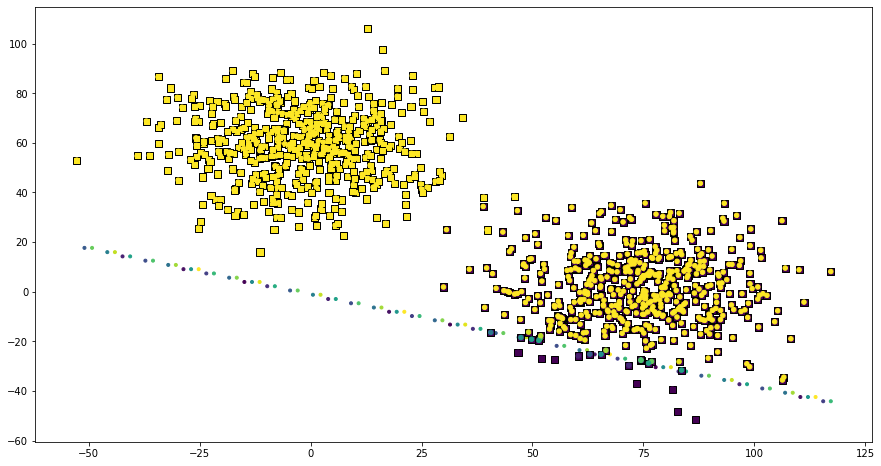

In [112]:
visualize_grid(X, theta, line_only=True)

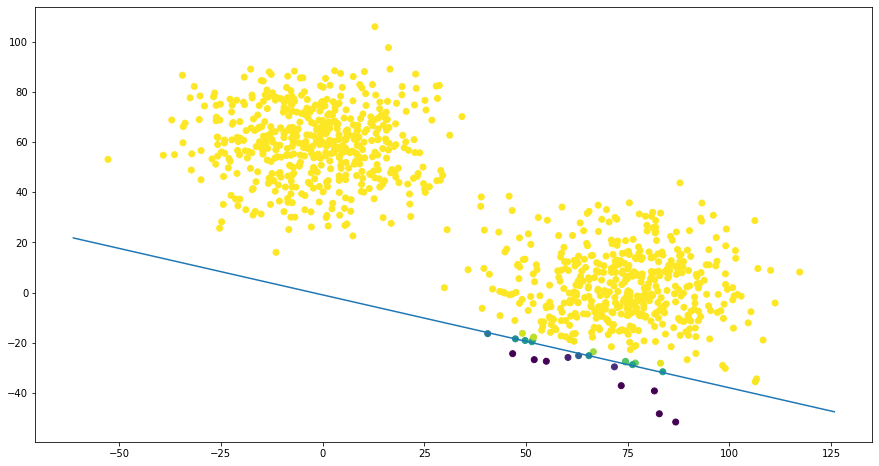

In [113]:
def visualize_line(X_I, theta):
    plt.scatter(X_I[:, 1], X_I[:, 2], c=predict(X_I, theta))
    ax = plt.gca()
    x0 = np.array(ax.get_xlim())
    x1 = -(theta[0] + theta[1] * x0) / theta[2]
    ax.plot(x0, x1)

visualize_line(X_I, theta)

Let's visualize cost function surface in 3d space. For this compute cost function value for a grid-shaped set of theta:

In [114]:
size = 100 # amount of tries for each parameter
limits = (-50, 50) # range of values for each parameter
error = np.zeros((size, size)) # empty matrix of errors

for i, w in enumerate(np.linspace(*limits, size)): # for each theta[0] component
    for j, b in enumerate(np.linspace(*limits, size)): # for each theta[1] component       
        error[i, j] = computeCost(X_I, y, np.array([0, w, b])) # compute cost for each theta

<ipython-input-87-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


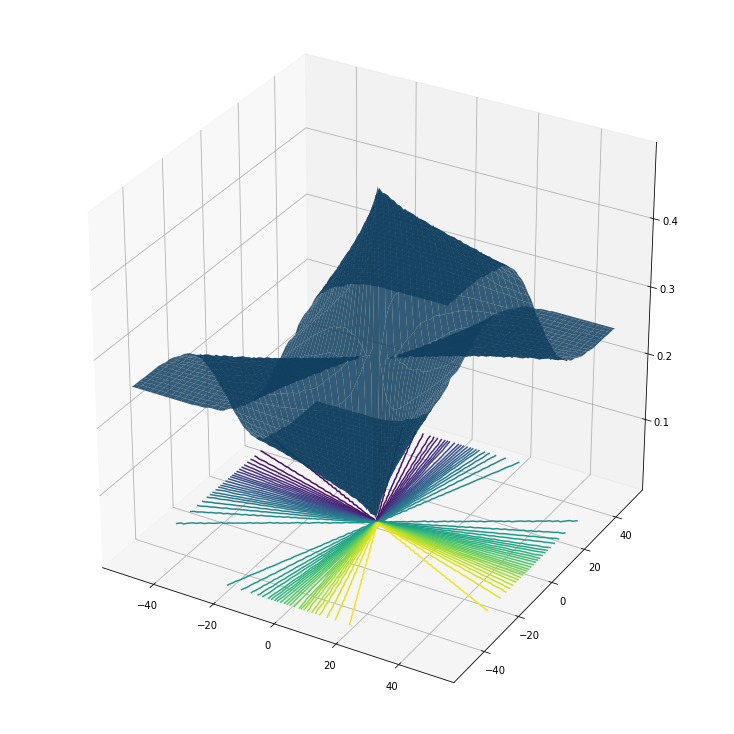

In [115]:
# initialize figure
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

# create 2d array for each index 
L, K = np.meshgrid(np.linspace(*limits, size), np.linspace(*limits, size))

ax.plot_surface(K, L, Z=error, alpha=0.85) # plot cost function surface in 3d
plt.contour(K, L, error, 50, offset=0) # plot cost function 2d-projection

Observe, how changes in dataset impacts cost function surface.

# Learn model

### Define learning algorithm

Simple gradient descent algorithm: 

$\nabla J(\theta) = \sum_m^i(y_i - h_\theta(x_i))x_i$

$\theta = \theta + \alpha \nabla J(\theta)$

In [145]:
def gradientDescent(X, y, init=1, alpha=0.001, iters=100):
    theta = np.ones_like(X[0]) * init # init theta with any scalar or vector
    m = len(X) 
    history = [] # list of theta values on each iteration 
    cost = [] # list of cost function values on each iteration
    
    for _ in range(iters):
        history.append(theta)
        cost.append(computeCost(X, y, theta))
        
        gradient = 1/m * np.dot(X.T, (predict(X, theta) - y))
        theta = theta + alpha * gradient # gradient descent itself, vectorized

    return theta, np.array(cost), np.array(history)

Initialize learning

In [120]:
alpha = 0.001
iters = 100

Learn model

In [138]:
w, cost, history = gradientDescent(X_I, y, 
                                   alpha=alpha, 
                                   iters=iters, 
                                   init=10) # initialize with far point for better visualization

before
[10. 10. 10.]
after
[10.00049    10.03622277 10.00056293]
before
[10.00049    10.03622277 10.00056293]
after
[10.00098    10.07244554 10.00112586]
before
[10.00098    10.07244554 10.00112586]
after
[10.00147    10.10866832 10.00168878]
before
[10.00147    10.10866832 10.00168878]
after
[10.00196    10.14489112 10.00225168]
before
[10.00196    10.14489112 10.00225168]
after
[10.00245    10.18111408 10.00281442]
before
[10.00245    10.18111408 10.00281442]
after
[10.00293997 10.21733808 10.00337611]
before
[10.00293997 10.21733808 10.00337611]
after
[10.00342984 10.25356798 10.00393186]
before
[10.00342984 10.25356798 10.00393186]
after
[10.00391933 10.28981745 10.00446793]
before
[10.00391933 10.28981745 10.00446793]
after
[10.00440846 10.32608617 10.00498464]
before
[10.00440846 10.32608617 10.00498464]
after
[10.00489747 10.36236063 10.00549558]
before
[10.00489747 10.36236063 10.00549558]
after
[10.00538647 10.39863624 10.00600535]
before
[10.00538647 10.39863624 10.00600535]


In [139]:
print("Model's cost: ", computeCost(X_I, y, w))
print("Calculated weights: ", w)

Model's cost:  0.24650000000000002
Calculated weights:  [10.04877273 13.63053718 10.04780596]


Visualize model

<ipython-input-87-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


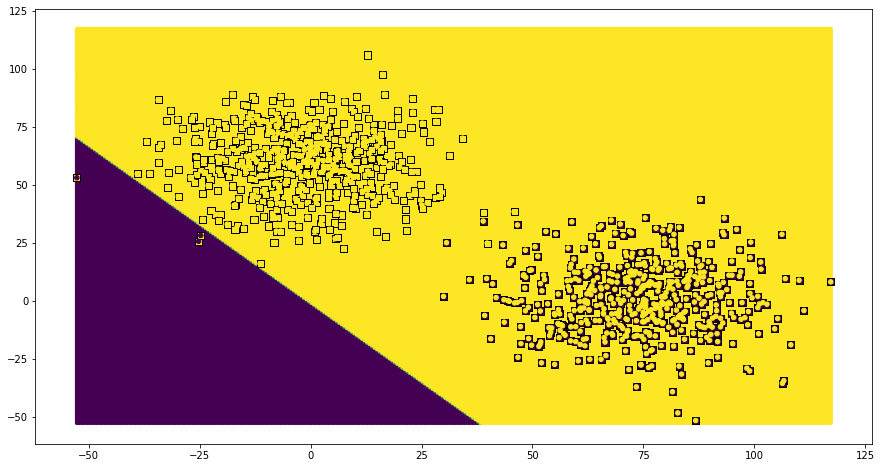

In [140]:
visualize_grid(X, w, resolution=300)

### Visualize learning process

Cost function history:

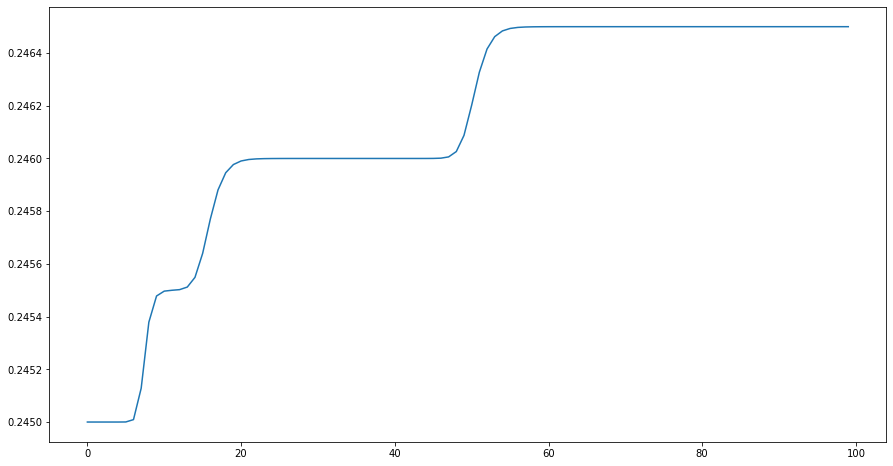

In [128]:
plt.plot(cost)

(Do you understand why it looks like this?)

Model's trajectory on cost function surface:

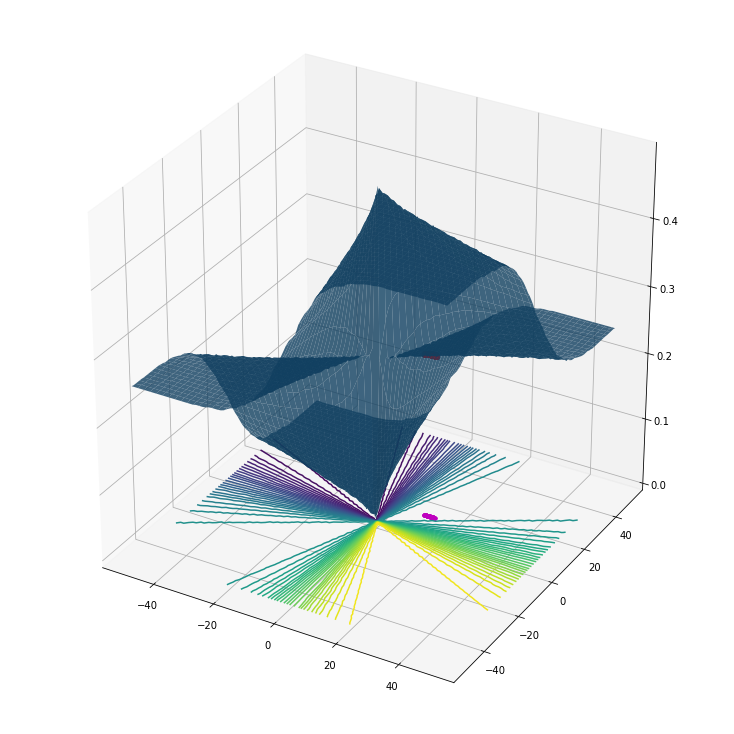

In [129]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

ax.plot_surface(K, L, Z=error, alpha=0.8)
ax.plot3D(history[:, 1], history[:, 2], cost, 'ro-')

plt.contour(K, L, error, 50, offset=0)
plt.plot(history[:, 1], history[:, 2], 'm.-')

#### Add stochastic mode for gradient descent:

In [130]:
def StochasticGD(X, y, alpha, iters, batch_size, init=1):
    theta = np.ones_like(X[0]) * init
    # unnecessary variables for visualization purposes
    cost = []
    history = []
    data = [] # put batches here
    
    for i in range(iters):
        history.append(theta)
        cost.append(computeCost(X, y, theta))
        
        idx = np.random.choice(len(X), replace=False, size=batch_size) # choose random batch from dataset
        data.append((X[:, 1][idx], X[:, 2][idx], y[idx]))
        theta, _, _ = gradientDescent(X[idx], y[idx], 
                                      alpha=alpha, 
                                      iters=1, 
                                      init=theta)
    
    return theta, np.array(cost), np.array(history), np.array(data)

In [131]:
w, cost, history, data = StochasticGD(X_I, y, 
                                alpha=0.001, 
                                iters=iters * 50, 
                                batch_size=15, 
                                init=10)

before
[10. 10. 10.]
after
[10.00033333 10.02498722 10.00361613]
before
[10.00033333 10.02498722 10.00361613]
after
[10.00086667 10.06736065  9.99800336]
before
[10.00086667 10.06736065  9.99800336]
after
[10.00106667 10.08446732  9.99888666]
before
[10.00106667 10.08446732  9.99888666]
after
[10.00173333 10.13690655  9.99656551]
before
[10.00173333 10.13690655  9.99656551]
after
[10.00213333 10.16852621  9.99661923]
before
[10.00213333 10.16852621  9.99661923]
after
[10.00286667 10.22638243  9.99518198]
before
[10.00286667 10.22638243  9.99518198]
after
[10.0034     10.26650936  9.99498123]
before
[10.0034     10.26650936  9.99498123]
after
[10.0036     10.2836681   9.99531119]
before
[10.0036     10.2836681   9.99531119]
after
[10.00413333 10.32489638  9.99508549]
before
[10.00413333 10.32489638  9.99508549]
after
[10.00466667 10.3687437   9.99050028]
before
[10.00466667 10.3687437   9.99050028]
after
[10.00506667 10.398214    9.99278591]
before
[10.00506667 10.398214    9.99278591]


[10.13173598 20.03662182 10.13914685]
before
[10.13173598 20.03662182 10.13914685]
after
[10.13233571 20.09273422 10.13814628]
before
[10.13233571 20.09273422 10.13814628]
after
[10.13300238 20.14265048 10.14065892]
before
[10.13300238 20.14265048 10.14065892]
after
[10.13373571 20.19809772 10.14132493]
before
[10.13373571 20.19809772 10.14132493]
after
[10.13426905 20.24172441 10.14875612]
before
[10.13426905 20.24172441 10.14875612]
after
[10.13466905 20.27198065 10.14950322]
before
[10.13466905 20.27198065 10.14950322]
after
[10.13480238 20.29177379 10.14613713]
before
[10.13480238 20.29177379 10.14613713]
after
[10.13513571 20.32641684 10.14847243]
before
[10.13513571 20.32641684 10.14847243]
after
[10.13573571 20.3719563  10.14889481]
before
[10.13573571 20.3719563  10.14889481]
after
[10.13606904 20.40259159 10.14530219]
before
[10.13606904 20.40259159 10.14530219]
after
[10.13613571 20.41465011 10.14342517]
before
[10.13613571 20.41465011 10.14342517]
after
[10.13646904 20.44400

<ipython-input-87-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


before
[10.2607025  30.77902444  9.68223242]
after
[10.26116917 30.82948812  9.67647613]
before
[10.26116917 30.82948812  9.67647613]
after
[10.26156917 30.86173499  9.67056356]
before
[10.26156917 30.86173499  9.67056356]
after
[10.26163584 30.89607353  9.65669076]
before
[10.26163584 30.89607353  9.65669076]
after
[10.26223584 30.94929416  9.65597562]
before
[10.26223584 30.94929416  9.65597562]
after
[10.2627025  30.99243436  9.65430804]
before
[10.2627025  30.99243436  9.65430804]
after
[10.26303584 31.02486103  9.65018551]
before
[10.26303584 31.02486103  9.65018551]
after
[10.2637025  31.07177955  9.64874073]
before
[10.2637025  31.07177955  9.64874073]
after
[10.2643025  31.11535946  9.64798369]
before
[10.2643025  31.11535946  9.64798369]
after
[10.2645025  31.15195553  9.63520393]
before
[10.2645025  31.15195553  9.63520393]
after
[10.26490246 31.19667857  9.63116513]
before
[10.26490246 31.19667857  9.63116513]
after
[10.26510246 31.22580362  9.61936125]
before
[10.26510246 3

before
[10.38010218 42.38741025  8.26011748]
after
[10.38056885 42.42574263  8.25659975]
before
[10.38056885 42.42574263  8.25659975]
after
[10.38090218 42.45543245  8.257267  ]
before
[10.38090218 42.45543245  8.257267  ]
after
[10.38116885 42.47219095  8.25625832]
before
[10.38116885 42.47219095  8.25625832]
after
[10.38143552 42.50718226  8.24241305]
before
[10.38143552 42.50718226  8.24241305]
after
[10.38190218 42.55549884  8.23295397]
before
[10.38190218 42.55549884  8.23295397]
after
[10.38244319 42.60262444  8.23001819]
before
[10.38244319 42.60262444  8.23001819]
after
[10.38297652 42.64133688  8.22836308]
before
[10.38297652 42.64133688  8.22836308]
after
[10.38344319 42.68095703  8.22509534]
before
[10.38344319 42.68095703  8.22509534]
after
[10.38357652 42.71654979  8.21008137]
before
[10.38357652 42.71654979  8.21008137]
after
[10.38384319 42.76307603  8.1971612 ]
before
[10.38384319 42.76307603  8.1971612 ]
after
[10.38430985 42.80859608  8.19593658]
before
[10.38430985 4

before
[10.47826422 54.18838804  5.59764432]
after
[10.47886422 54.2483351   5.59353504]
before
[10.47886422 54.2483351   5.59353504]
after
[10.47906422 54.29235727  5.56790638]
before
[10.47906422 54.29235727  5.56790638]
after
[10.47946422 54.33743856  5.56705316]
before
[10.47946422 54.33743856  5.56705316]
after
[10.47986422 54.37384686  5.56265684]
before
[10.47986422 54.37384686  5.56265684]
after
[10.47993089 54.39509909  5.55198553]
before
[10.47993089 54.39509909  5.55198553]
after
[10.47993089 54.41933203  5.53528911]
before
[10.47993089 54.41933203  5.53528911]
after
[10.48039756 54.45336505  5.53839198]
before
[10.48039756 54.45336505  5.53839198]
after
[10.48059756 54.48427424  5.53103854]
before
[10.48059756 54.48427424  5.53103854]
after
[10.48066422 54.50946466  5.51868968]
before
[10.48066422 54.50946466  5.51868968]
after
[10.48079756 54.5493492   5.5005102 ]
before
[10.48079756 54.5493492   5.5005102 ]
after
[10.48092924 54.59074494  5.48458316]
before
[10.48092924 5

before
[10.56133608 66.22992967  1.88860947]
after
[10.56140275 66.25826102  1.86897112]
before
[10.56140275 66.25826102  1.86897112]
after
[10.56173608 66.29813152  1.85172809]
before
[10.56173608 66.29813152  1.85172809]
after
[10.56193608 66.34045568  1.83431599]
before
[10.56193608 66.34045568  1.83431599]
after
[10.56233608 66.38845654  1.82164198]
before
[10.56233608 66.38845654  1.82164198]
after
[10.56246941 66.42846221  1.80378609]
before
[10.56246941 66.42846221  1.80378609]
after
[10.56266941 66.46276576  1.7929722 ]
before
[10.56266941 66.46276576  1.7929722 ]
after
[10.56286941 66.50978284  1.77020954]
before
[10.56286941 66.50978284  1.77020954]
after
[10.56320275 66.54937386  1.75418502]
before
[10.56320275 66.54937386  1.75418502]
after
[10.56366941 66.58952327  1.75095498]
before
[10.56366941 66.58952327  1.75095498]
after
[10.56406941 66.62203964  1.7445609 ]
before
[10.56406941 66.62203964  1.7445609 ]
after
[10.56440275 66.66811823  1.73406134]
before
[10.56440275 6

before
[10.6260642 77.0113911 -2.0260169]
after
[10.62633087 77.04823883 -2.046455  ]
before
[10.62633087 77.04823883 -2.046455  ]
after
[10.62659754 77.07991408 -2.0533886 ]
before
[10.62659754 77.07991408 -2.0533886 ]
after
[10.6266642  77.12230654 -2.07882443]
before
[10.6266642  77.12230654 -2.07882443]
after
[10.62699754 77.17757143 -2.10012006]
before
[10.62699754 77.17757143 -2.10012006]
after
[10.62693087 77.20998206 -2.12918659]
before
[10.62693087 77.20998206 -2.12918659]
after
[10.62699759 77.24238345 -2.14162539]
before
[10.62699759 77.24238345 -2.14162539]
after
[10.62753092 77.28526393 -2.14540832]
before
[10.62753092 77.28526393 -2.14540832]
after
[10.62719762 77.31076521 -2.18056948]
before
[10.62719762 77.31076521 -2.18056948]
after
[10.62759762 77.35674332 -2.18466529]
before
[10.62759762 77.35674332 -2.18466529]
after
[10.62799762 77.40123527 -2.19605103]
before
[10.62799762 77.40123527 -2.19605103]
after
[10.62806429 77.43680734 -2.21421936]
before
[10.62806429 77.4

before
[10.6784909  88.89436628 -7.49362407]
after
[10.67882424 88.94658059 -7.50683206]
before
[10.67882424 88.94658059 -7.50683206]
after
[10.67895757 88.98331478 -7.52602718]
before
[10.67895757 88.98331478 -7.52602718]
after
[10.67962424 89.04112521 -7.52430726]
before
[10.67962424 89.04112521 -7.52430726]
after
[10.6792909  89.06729171 -7.56308866]
before
[10.6792909  89.06729171 -7.56308866]
after
[10.67922424 89.09729741 -7.5897755 ]
before
[10.67922424 89.09729741 -7.5897755 ]
after
[10.6794909  89.1433828  -7.60932735]
before
[10.6794909  89.1433828  -7.60932735]
after
[10.6796909  89.18664455 -7.63329816]
before
[10.6796909  89.18664455 -7.63329816]
after
[10.67962424 89.21528308 -7.65602837]
before
[10.67962424 89.21528308 -7.65602837]
after
[10.6796909  89.24743141 -7.67815081]
before
[10.6796909  89.24743141 -7.67815081]
after
[10.67975757 89.28014404 -7.69908396]
before
[10.67975757 89.28014404 -7.69908396]
after
[10.67942424 89.30496591 -7.73345191]
before
[10.67942424 8

before
[ 10.716532   100.4872528  -13.64092958]
after
[ 10.71599866 100.50473332 -13.68236687]
before
[ 10.71599866 100.50473332 -13.68236687]
after
[ 10.71639866 100.55661462 -13.69344315]
before
[ 10.71639866 100.55661462 -13.69344315]
after
[ 10.71666533 100.6007792  -13.71565373]
before
[ 10.71666533 100.6007792  -13.71565373]
after
[ 10.71659867 100.64162632 -13.74910985]
before
[ 10.71659867 100.64162632 -13.74910985]
after
[ 10.71686533 100.68368942 -13.7630258 ]
before
[ 10.71686533 100.68368942 -13.7630258 ]
after
[ 10.71686533 100.72039258 -13.788743  ]
before
[ 10.71686533 100.72039258 -13.788743  ]
after
[ 10.71686533 100.7477125  -13.8095462 ]
before
[ 10.71686533 100.7477125  -13.8095462 ]
after
[ 10.716932   100.78777451 -13.8345879 ]
before
[ 10.716932   100.78777451 -13.8345879 ]
after
[ 10.71746533 100.84197202 -13.83887764]
before
[ 10.71746533 100.84197202 -13.83887764]
after
[ 10.71819867 100.90840932 -13.84418896]
before
[ 10.71819867 100.90840932 -13.84418896]
af

before
[ 10.7512026  112.89380338 -20.66465006]
after
[ 10.7510026  112.92272545 -20.7034095 ]
before
[ 10.7510026  112.92272545 -20.7034095 ]
after
[ 10.7512026  112.96420399 -20.72532812]
before
[ 10.7512026  112.96420399 -20.72532812]
after
[ 10.75126927 112.99488117 -20.74864323]
before
[ 10.75126927 112.99488117 -20.74864323]
after
[ 10.7512026  113.03442264 -20.77311653]
before
[ 10.7512026  113.03442264 -20.77311653]
after
[ 10.7510026  113.06008944 -20.80250968]
before
[ 10.7510026  113.06008944 -20.80250968]
after
[ 10.7512026  113.09582112 -20.81794418]
before
[ 10.7512026  113.09582112 -20.81794418]
after
[ 10.75166927 113.15111036 -20.83082781]
before
[ 10.75166927 113.15111036 -20.83082781]
after
[ 10.7518026  113.18745025 -20.84966605]
before
[ 10.7518026  113.18745025 -20.84966605]
after
[ 10.75173594 113.21941926 -20.87983406]
before
[ 10.75173594 113.21941926 -20.87983406]
after
[ 10.75206927 113.2694943  -20.89528148]
before
[ 10.75206927 113.2694943  -20.89528148]
af

before
[ 10.76854337 123.39237251 -27.47921545]
after
[ 10.76807671 123.40714237 -27.51342514]
before
[ 10.76807671 123.40714237 -27.51342514]
after
[ 10.76781004 123.43567264 -27.55003118]
before
[ 10.76781004 123.43567264 -27.55003118]
after
[ 10.76787671 123.47591274 -27.57600612]
before
[ 10.76787671 123.47591274 -27.57600612]
after
[ 10.76787671 123.51103229 -27.6014548 ]
before
[ 10.76787671 123.51103229 -27.6014548 ]
after
[ 10.76834337 123.5671417  -27.61099989]
before
[ 10.76834337 123.5671417  -27.61099989]
after
[ 10.76861004 123.60806056 -27.62385127]
before
[ 10.76861004 123.60806056 -27.62385127]
after
[ 10.76861004 123.64385126 -27.64986562]
before
[ 10.76861004 123.64385126 -27.64986562]
after
[ 10.76881004 123.68873144 -27.67497339]
before
[ 10.76881004 123.68873144 -27.67497339]
after
[ 10.76894337 123.72694542 -27.69942386]
before
[ 10.76894337 123.72694542 -27.69942386]
after
[ 10.76947671 123.78312136 -27.71410798]
before
[ 10.76947671 123.78312136 -27.71410798]
af

before
[ 10.78367485 135.73519204 -35.84828443]
after
[ 10.78380819 135.77287569 -35.86845009]
before
[ 10.78380819 135.77287569 -35.86845009]
after
[ 10.78387485 135.81156056 -35.89407972]
before
[ 10.78387485 135.81156056 -35.89407972]
after
[ 10.78387501 135.84149362 -35.92265022]
before
[ 10.78387501 135.84149362 -35.92265022]
after
[ 10.78354168 135.86161561 -35.95728129]
before
[ 10.78354168 135.86161561 -35.95728129]
after
[ 10.78360835 135.90341643 -35.98579312]
before
[ 10.78360835 135.90341643 -35.98579312]
after
[ 10.78340835 135.93969229 -36.01861329]
before
[ 10.78340835 135.93969229 -36.01861329]
after
[ 10.78334168 135.97081609 -36.04552977]
before
[ 10.78334168 135.97081609 -36.04552977]
after
[ 10.78300835 136.00038382 -36.08951108]
before
[ 10.78300835 136.00038382 -36.08951108]
after
[ 10.78327501 136.0431706  -36.10708283]
before
[ 10.78327501 136.0431706  -36.10708283]
after
[ 10.78320835 136.07839505 -36.14560377]
before
[ 10.78320835 136.07839505 -36.14560377]
af

before
[ 10.79549809 147.44165926 -44.03690434]
after
[ 10.79556475 147.48390382 -44.07259347]
before
[ 10.79556475 147.48390382 -44.07259347]
after
[ 10.79603142 147.54138397 -44.08937668]
before
[ 10.79603142 147.54138397 -44.08937668]
after
[ 10.79649809 147.596528   -44.10966502]
before
[ 10.79649809 147.596528   -44.10966502]
after
[ 10.79656475 147.63294909 -44.1348683 ]
before
[ 10.79656475 147.63294909 -44.1348683 ]
after
[ 10.79623142 147.66086154 -44.17894011]
before
[ 10.79623142 147.66086154 -44.17894011]
after
[ 10.79643142 147.70726879 -44.20362466]
before
[ 10.79643142 147.70726879 -44.20362466]
after
[ 10.79643142 147.74378744 -44.23376314]
before
[ 10.79643142 147.74378744 -44.23376314]
after
[ 10.79636475 147.77901098 -44.26335726]
before
[ 10.79636475 147.77901098 -44.26335726]
after
[ 10.79616475 147.81262649 -44.30392702]
before
[ 10.79616475 147.81262649 -44.30392702]
after
[ 10.79629809 147.85154561 -44.33111656]
before
[ 10.79629809 147.85154561 -44.33111656]
af

before
[ 10.80089745 158.32154873 -51.97111279]
after
[ 10.80083079 158.35395648 -52.00117326]
before
[ 10.80083079 158.35395648 -52.00117326]
after
[ 10.80056412 158.38055588 -52.04049413]
before
[ 10.80056412 158.38055588 -52.04049413]
after
[ 10.80016412 158.39976857 -52.07998988]
before
[ 10.80016412 158.39976857 -52.07998988]
after
[ 10.80036412 158.44298172 -52.10140926]
before
[ 10.80036412 158.44298172 -52.10140926]
after
[ 10.80043079 158.48990918 -52.12832385]
before
[ 10.80043079 158.48990918 -52.12832385]
after
[ 10.80036412 158.51829114 -52.16210866]
before
[ 10.80036412 158.51829114 -52.16210866]
after
[ 10.80063079 158.55967796 -52.18792883]
before
[ 10.80063079 158.55967796 -52.18792883]
after
[ 10.80043079 158.59408235 -52.2254407 ]
before
[ 10.80043079 158.59408235 -52.2254407 ]
after
[ 10.80023079 158.62614806 -52.26162241]
before
[ 10.80023079 158.62614806 -52.26162241]
after
[ 10.80043079 158.67239425 -52.28898278]
before
[ 10.80043079 158.67239425 -52.28898278]
af

before
[ 10.80623222 169.30885665 -60.02126696]
after
[ 10.80589888 169.34027374 -60.06486602]
before
[ 10.80589888 169.34027374 -60.06486602]
after
[ 10.80609888 169.38526201 -60.07986503]
before
[ 10.80609888 169.38526201 -60.07986503]
after
[ 10.80623222 169.42265734 -60.10382203]
before
[ 10.80623222 169.42265734 -60.10382203]
after
[ 10.80616555 169.45663454 -60.14491402]
before
[ 10.80616555 169.45663454 -60.14491402]
after
[ 10.80649888 169.51028436 -60.16294644]
before
[ 10.80649888 169.51028436 -60.16294644]
after
[ 10.80649888 169.54281655 -60.19658251]
before
[ 10.80649888 169.54281655 -60.19658251]
after
[ 10.80623222 169.56511719 -60.22905918]
before
[ 10.80623222 169.56511719 -60.22905918]
after
[ 10.80616555 169.6019059  -60.26427189]
before
[ 10.80616555 169.6019059  -60.26427189]
after
[ 10.80623222 169.64147868 -60.29226494]
before
[ 10.80623222 169.64147868 -60.29226494]
after
[ 10.80629888 169.68448671 -60.30997802]
before
[ 10.80629888 169.68448671 -60.30997802]
af

before
[ 10.81283222 178.09672297 -66.30841748]
after
[ 10.81263222 178.13138951 -66.34658969]
before
[ 10.81263222 178.13138951 -66.34658969]
after
[ 10.81216555 178.15820865 -66.39578214]
before
[ 10.81216555 178.15820865 -66.39578214]
after
[ 10.81236555 178.19612225 -66.41867666]
before
[ 10.81236555 178.19612225 -66.41867666]
after
[ 10.81203222 178.22209495 -66.46198147]
before
[ 10.81203222 178.22209495 -66.46198147]
after
[ 10.81196555 178.261918   -66.49488514]
before
[ 10.81196555 178.261918   -66.49488514]
after
[ 10.81216555 178.30626029 -66.51437196]
before
[ 10.81216555 178.30626029 -66.51437196]
after
[ 10.81223222 178.34369294 -66.54134366]
before
[ 10.81223222 178.34369294 -66.54134366]
after
[ 10.81229888 178.3916722  -66.56775188]
before
[ 10.81229888 178.3916722  -66.56775188]
after
[ 10.81263222 178.43706427 -66.58591299]
before
[ 10.81263222 178.43706427 -66.58591299]
after
[ 10.81283222 178.48620204 -66.60986833]
before
[ 10.81283222 178.48620204 -66.60986833]
af

before
[ 10.81596574 186.61444041 -72.6524305 ]
after
[ 10.81576574 186.64084571 -72.68985621]
before
[ 10.81576574 186.64084571 -72.68985621]
after
[ 10.81576574 186.67247806 -72.7196186 ]
before
[ 10.81576574 186.67247806 -72.7196186 ]
after
[ 10.81549907 186.69516248 -72.7583825 ]
before
[ 10.81549907 186.69516248 -72.7583825 ]
after
[ 10.81569907 186.73982531 -72.78576331]
before
[ 10.81569907 186.73982531 -72.78576331]
after
[ 10.8158324  186.78895367 -72.81035657]
before
[ 10.8158324  186.78895367 -72.81035657]
after
[ 10.8156324  186.82205989 -72.8493699 ]
before
[ 10.8156324  186.82205989 -72.8493699 ]
after
[ 10.81576574 186.85895338 -72.87337966]
before
[ 10.81576574 186.85895338 -72.87337966]
after
[ 10.8162324  186.90211318 -72.8883084 ]
before
[ 10.8162324  186.90211318 -72.8883084 ]
after
[ 10.81616574 186.93833958 -72.92424638]
before
[ 10.81616574 186.93833958 -72.92424638]
after
[ 10.81636574 186.98721932 -72.9456575 ]
before
[ 10.81636574 186.98721932 -72.9456575 ]
af

before
[ 10.81996574 196.25310784 -79.72138827]
after
[ 10.81976574 196.2820961  -79.75743594]
before
[ 10.81976574 196.2820961  -79.75743594]
after
[ 10.81976574 196.31895174 -79.7835148 ]
before
[ 10.81976574 196.31895174 -79.7835148 ]
after
[ 10.81969907 196.35889378 -79.8114931 ]
before
[ 10.81969907 196.35889378 -79.8114931 ]
after
[ 10.81949907 196.39308078 -79.85366654]
before
[ 10.81949907 196.39308078 -79.85366654]
after
[ 10.8198324  196.43981388 -79.87635532]
before
[ 10.8198324  196.43981388 -79.87635532]
after
[ 10.82049907 196.50141502 -79.88584318]
before
[ 10.82049907 196.50141502 -79.88584318]
after
[ 10.8204324  196.53698087 -79.91796127]
before
[ 10.8204324  196.53698087 -79.91796127]
after
[ 10.82049907 196.57562452 -79.94589975]
before
[ 10.82049907 196.57562452 -79.94589975]
after
[ 10.82056574 196.61080764 -79.97770632]
before
[ 10.82056574 196.61080764 -79.97770632]
after
[ 10.82056574 196.64630197 -80.00530909]
before
[ 10.82056574 196.64630197 -80.00530909]
af

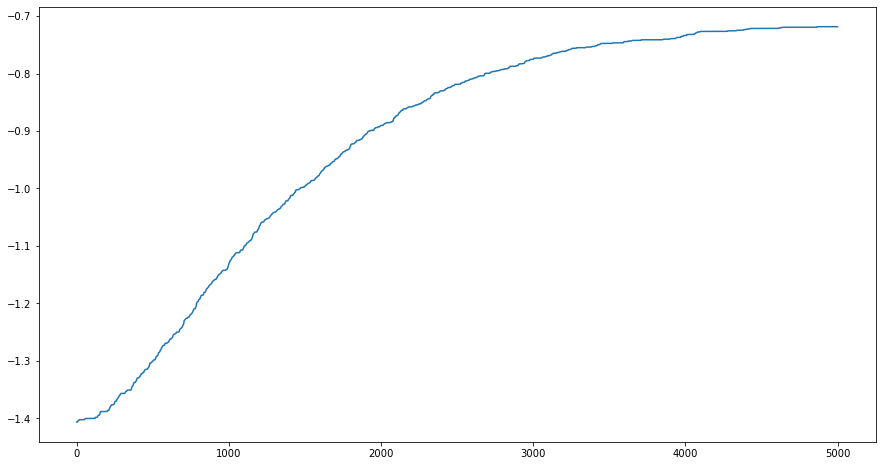

In [132]:
plt.plot(np.log(cost)) # often looks beter in log scale

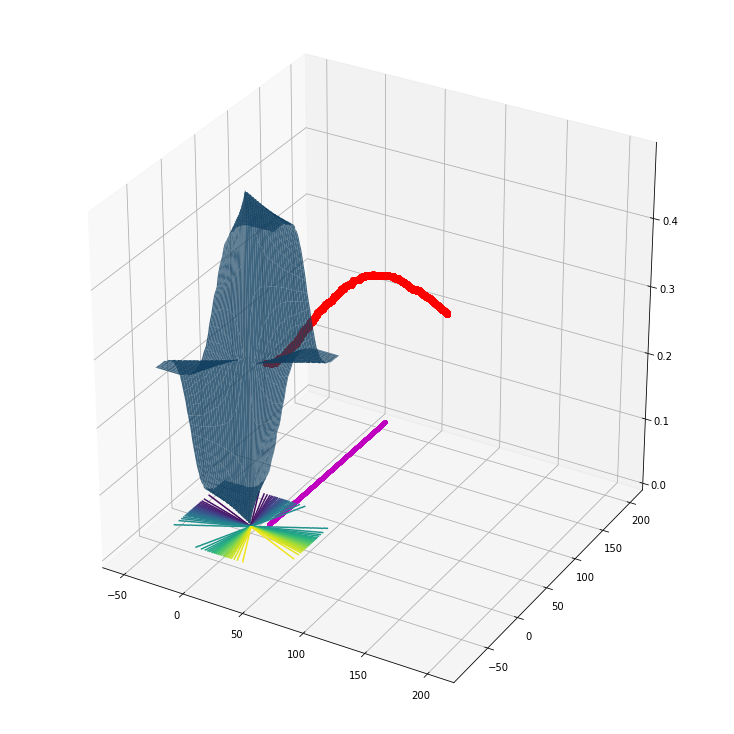

In [133]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

ax.plot_surface(K, L, Z=error, alpha=0.8)
ax.plot3D(history[:, 1], history[:, 2], cost, 'ro-')

plt.contour(K, L, error, 50, offset=0)
plt.plot(history[:, 0], history[:, 1], 'm.-')

(Why trajectory looks smoother?)

<ipython-input-87-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


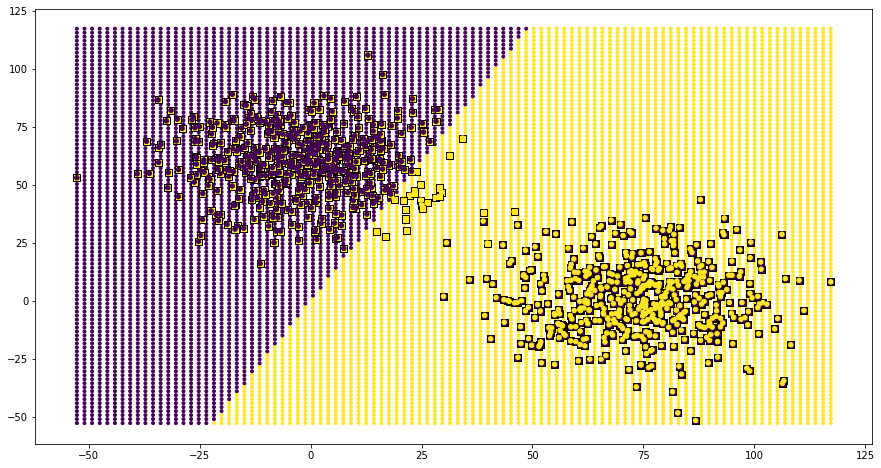

In [134]:
visualize_grid(X, w)

In [135]:
print("Model's cost: ", computeCost(X_I, y, w))
print("Calculated weights: ", w)

Model's cost:  0.4875
Calculated weights:  [ 10.82349907 202.49922757 -84.40337601]


<ipython-input-87-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Compare with _random model_ cost value and other methods results 

# Additional tasks

## Taks 1

Apply and visualize sklearn [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [177]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X, y)
clf_w = [*clf.intercept_, *clf.coef_[0]]
clf_w

[-0.3612622920400731, -0.20758746762381644, 0.26732301471106423]

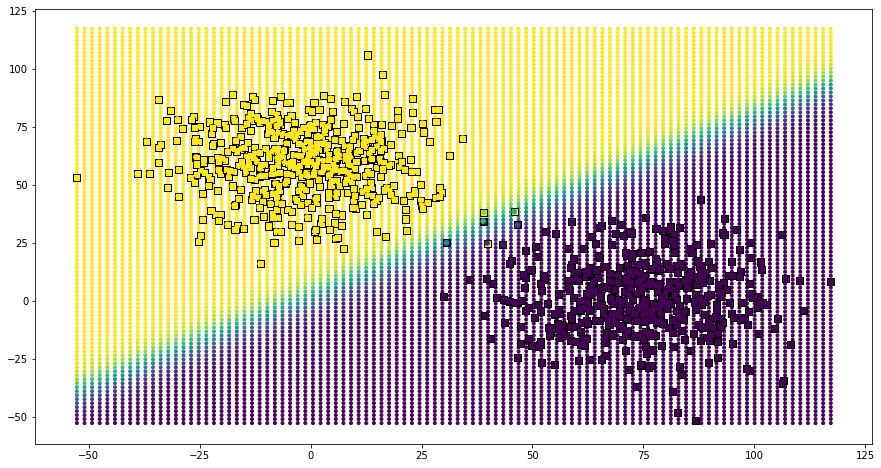

In [178]:
visualize_grid(X, clf_w)

## Taks 2

Change data distribution and try Generalizaed Linear Model (for example from [here](https://www.statsmodels.org/stable/glm.html))

In [0]:
import statsmodels.api as sm